In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Foot_ulcer_torch')
sys.path.append('/content/drive/MyDrive/Foot_ulcer_torch/sm_library')
sys.path.append('/content/drive/MyDrive/Foot_ulcer_torch/utils')

In [ ]:
# !pip install segmentation-models-pytorch --target='/content/drive/MyDrive/Foot_ulcer_torch/sm_library'
# !pip install git+https://github.com/qubvel/segmentation_models.pytorch --target='/content/drive/MyDrive/Foot_ulcer_torch/sm_library'
# !pip install albumentations --target='/content/drive/MyDrive/Foot_ulcer_torch/sm_library'
# !pip install certifi --target='/content/drive/MyDrive/Foot_ulcer_torch/sm_library'

In [ ]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import albumentations as albu
import cv2
import numpy as np
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.utils import metrics, losses, base
import random
import matplotlib.pyplot as plt
import os
from copy import deepcopy
from datetime import datetime

%matplotlib inline

## Dataloader

In [ ]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    def __init__(
            self, 
            list_IDs,
            images_dir, 
            masks_dir, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = list_IDs
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
              
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        mask = cv2.imread(self.masks_fps[i], 0) # graychannel # ----------------- pay attention ------------------ #
        mask = mask/255.0   # converting mask to (0 and 1) # ----------------- pay attention ------------------ #
        mask = np.expand_dims(mask, axis=-1)  # adding channel axis # ----------------- pay attention ------------------ #
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

## Augmentation

In [ ]:
def get_training_augmentation():
    train_transform = [

        albu.OneOf(
            [
                albu.HorizontalFlip(p=0.8),
                albu.VerticalFlip(p=0.4),
            ],
            p=0.5,
        ),
        
        albu.OneOf(
            [
                albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0, p=1, border_mode=0), # scale only
                albu.ShiftScaleRotate(scale_limit=0, rotate_limit=30, shift_limit=0, p=1, border_mode=0), # rotate only
                albu.ShiftScaleRotate(scale_limit=0, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0), # shift only
                albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=30, shift_limit=0.1, p=1, border_mode=0), # affine transform
            ],
            p=0.9,
        ),

        # albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        # albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.OneOf(
            [
                albu.Perspective(p=1),
                albu.GaussNoise(p=1),
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.2,
        ),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1),
                albu.RandomGamma(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.2,
        ),
        
    ]

    return albu.Compose(train_transform, p=0.9) # 90% augmentation probability


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        # albu.PadIfNeeded(512, 512)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform) 

## Split dataset

In [ ]:
#%% Load dataset
x_test_dir = '/content/drive/MyDrive/Dataset/azh_wound_care_center_dataset_patches/test/images'
y_test_dir = '/content/drive/MyDrive/Dataset/azh_wound_care_center_dataset_patches/test/labels'

list_IDs_test = os.listdir(x_test_dir)

print('No. of test images: ', len(list_IDs_test))

No. of test images:  278


In [ ]:
list_IDs_test.index('b23232898bafcf304b2138af86be40b9_0.png')
# list_IDs_test.index('fa6fb6f94a3ba6c9b98ba40a3e0d1175_2.png')

0

## Parameters

In [ ]:
# Parameters
BASE_MODEL = 'Unet+scse'
ENCODER = 'efficientnet-b7'
ENCODER_WEIGHTS = 'imagenet'
BATCH_SIZE = 2
n_classes = 1 
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LR = 0.0001 # learning rate
EPOCHS = 200
WEIGHT_DECAY = 1e-5
SAVE_WEIGHTS_ONLY = True
TO_CATEGORICAL = False
SAVE_BEST_MODEL = True
SAVE_LAST_MODEL = True

PERIOD = 10 # periodically save checkpoints
RAW_PREDICTION = False # if true, then stores raw predictions (i.e. before applying threshold)
RETRAIN = False

# For early stopping 
EARLY_STOP = False # True to activate early stopping
PATIENCE = 50 # for early stopping

# Build model

In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

aux_params=dict(
    classes=n_classes, 
    activation=ACTIVATION,
    dropout=0.1, # dropout ratio, default is None
)

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS,     
    # aux_params=aux_params,
    classes=n_classes, 
    activation=ACTIVATION,
    decoder_attention_type='scse',
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

## Loss, optimizer, metrics, and callbacks

In [ ]:
# Loss function
dice_loss = losses.DiceLoss()
focal_loss = losses.FocalLoss() 
total_loss = base.SumOfLosses(dice_loss, focal_loss)

# Metrics
metrics = [
    metrics.IoU(threshold=0.5),
    metrics.Fscore(threshold=0.5),
]

# Optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY),
])

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                              factor=0.1,
                              mode='min',
                              patience=10,
                              min_lr=0.00001,
                              verbose=True,
                              )

## Inference

Load model

In [ ]:
# load best saved checkpoint
model_name = 'Unet_pscsev1_efficientnet-b7_2023-02-28_10-05-44' # PscSE
# model_name = 'Unet+scse_additive_efficientnet-b7_2023-03-01_18-56-05' #scSE
# model_name = 'Unet+scse_efficientnet-b7_2023-02-19_01-21-41'
checkpoint_loc = '/content/drive/MyDrive/Foot_ulcer_torch/checkpoints_oldDfu/' + model_name

checkpoint = torch.load(os.path.join(checkpoint_loc, 'best_model.pth'))
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])

# Uncomment if to load periodically saved checkpoints
# model = torch.load(os.path.join(checkpoint_loc, 'cp-0050.pth'))

In [ ]:
model

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          64, 16, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          16, 64, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePaddi

In [ ]:
from torchsummary import summary 

In [ ]:
model.to("cuda")
summary(model, (3, 224, 224))

In [ ]:
# Extract all layers
layers = list(model.children())

In [ ]:
# Extract a layer
model.encoder._conv_stem

Conv2dStaticSamePadding(
  3, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
  (static_padding): ZeroPad2d((0, 1, 0, 1))
)

In [ ]:
model.decoder.blocks[0].conv1[2]

ReLU(inplace=True)

In [ ]:
model.decoder.blocks[0].attention2

SCSEModule0(
  (cSE): Sequential(
    (0): AdaptiveAvgPool2d(output_size=1)
    (1): Conv2d(864, 54, kernel_size=(1, 1), stride=(1, 1))
    (2): ReLU(inplace=True)
    (3): Conv2d(54, 864, kernel_size=(1, 1), stride=(1, 1))
    (4): Sigmoid()
  )
  (sSE): Sequential(
    (0): Conv2d(864, 1, kernel_size=(1, 1), stride=(1, 1))
    (1): Sigmoid()
  )
  (if_concat): Sequential(
    (0): Conv2d(1728, 864, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(864, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [ ]:
model

In [ ]:
# Create a hook
# (Ref: https://discuss.pytorch.org/t/how-can-l-load-my-best-model-as-a-feature-extractor-evaluator/17254/6,
# https://kozodoi.me/python/deep%20learning/pytorch/tutorial/2021/05/27/extracting-features.html)

int_feat = {} # intermediate features
def intermediate_features(name):
    def hook(model, input, output):
        int_feat[name] = output.detach()
    return hook

# model.decoder.blocks[0].conv1[2].register_forward_hook(intermediate_features('feat'))

model.decoder.blocks[0].attention1.register_forward_hook(intermediate_features('b0_attn1')) # max-out
model.decoder.blocks[0].attention2.register_forward_hook(intermediate_features('b0_attn2')) # additive

model.decoder.blocks[0].conv1.register_forward_hook(intermediate_features('b0_conv1'))

model.decoder.blocks[1].attention1.register_forward_hook(intermediate_features('b1_attn1')) # max-out
model.decoder.blocks[1].attention2.register_forward_hook(intermediate_features('b1_attn2')) # additive

model.decoder.blocks[1].conv1.register_forward_hook(intermediate_features('b1_conv1'))

model.decoder.blocks[2].attention1.register_forward_hook(intermediate_features('b2_attn1')) # max-out
model.decoder.blocks[2].attention2.register_forward_hook(intermediate_features('b2_attn2')) # additive

model.decoder.blocks[2].conv1.register_forward_hook(intermediate_features('b2_conv1'))

model.decoder.blocks[3].attention1.register_forward_hook(intermediate_features('b3_attn1')) # max-out
model.decoder.blocks[3].attention2.register_forward_hook(intermediate_features('b3_attn2')) # additive

model.decoder.blocks[3].conv1.register_forward_hook(intermediate_features('b3_conv1'))

# model.decoder.blocks[4].attention1.register_forward_hook(intermediate_features('b4_attn1')) # last stage don't have max-out
model.decoder.blocks[4].attention2.register_forward_hook(intermediate_features('b4_attn2')) # additive

model.decoder.blocks[4].conv1.register_forward_hook(intermediate_features('b4_conv1')) # final output


In [ ]:
test_dataset = Dataset(
    list_IDs_test,
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)

test_dataloader = DataLoader(test_dataset, 
                             batch_size=1, 
                             shuffle=False, 
                             num_workers=6)

it = iter(test_dataloader)

In [ ]:
img, mask = next(it)

In [ ]:
img.size()

torch.Size([1, 3, 224, 224])

In [ ]:
img2 = torch.permute(torch.squeeze(img), [-1, 1, 0]) # convert from CHW to HWC

In [ ]:
img2.size()

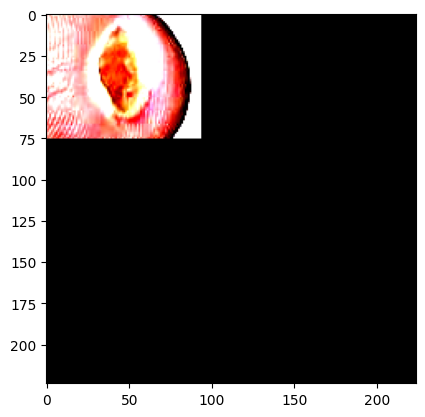

In [ ]:
plt.imshow(img2)

In [ ]:
# Run from Dataset class
idx = 273 #0 #273 # 12 # 10

# Read original image
org_img = cv2.imread(os.path.join(x_test_dir, list_IDs_test[idx]))[:,:,::-1]

# Read standardize image and mask using the Dataset class
img, mask = test_dataset[idx] # get image and mask
    
img = torch.from_numpy(img).to(DEVICE).unsqueeze(0) # convert to tensor and add batch axis

print('Image size:', img.size())

Image size: torch.Size([1, 3, 224, 224])


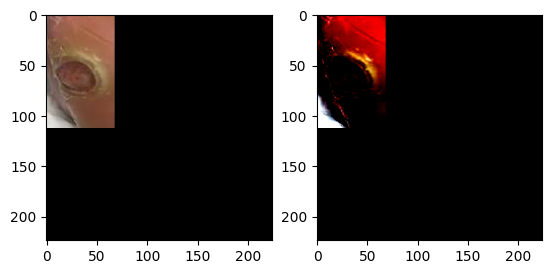

In [ ]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(org_img)
ax[1].imshow(img.squeeze().permute([1, 2, 0]).cpu())

In [ ]:
output = model(img.to(DEVICE))

b0_attn1 = int_feat["b0_attn1"]
b0_attn2 = int_feat["b0_attn2"]
b0_conv1 = int_feat["b0_conv1"]

b1_attn1 = int_feat["b1_attn1"]
b1_attn2 = int_feat["b1_attn2"]
b1_conv1 = int_feat["b1_conv1"]

b2_attn1 = int_feat["b2_attn1"]
b2_attn2 = int_feat["b2_attn2"]
b2_conv1 = int_feat["b2_conv1"]

b3_attn1 = int_feat["b3_attn1"]
b3_attn2 = int_feat["b3_attn2"]
b3_conv1 = int_feat["b3_conv1"]

# b4_attn1 = int_feat["b4_attn1"]
b4_attn2 = int_feat["b4_attn2"]
b4_conv1 = int_feat["b4_conv1"]

In [ ]:
def avg_output(input):
  """
  Take the average along the channel axis.

  Input
  -------
  input: A tensor. Size: batch x ch x H x W

  Output
  -------
  output: A tensor. Returns average image.

  """

  output = torch.squeeze(input)
  output = torch.sum(output, dim=0)
  output = output / output.size()[0]

  return output

In [ ]:
# Create output for visualization
# Output shape -> batch, channel, height, width

# int_output = torch.squeeze(int_out) 
# int_output = torch.sum(int_output, dim=0)
# int_output = int_output / int_output.size()[0]

b0_attn = avg_output(b0_attn1 + b0_attn2)
b0_conv1 = avg_output(b0_conv1)

b1_attn = avg_output(b1_attn1 + b1_attn2)
b1_conv1 = avg_output(b1_conv1)

b2_attn = avg_output(b2_attn1 + b2_attn2)
b2_conv1 = avg_output(b2_conv1)

b3_attn = avg_output(b3_attn1 + b3_attn2)
b3_conv1 = avg_output(b3_conv1)

b4_attn = avg_output(b4_attn2)
b4_conv1 = avg_output(b4_conv1)

In [ ]:
# int_output
b4_conv1.shape

torch.Size([224, 224])

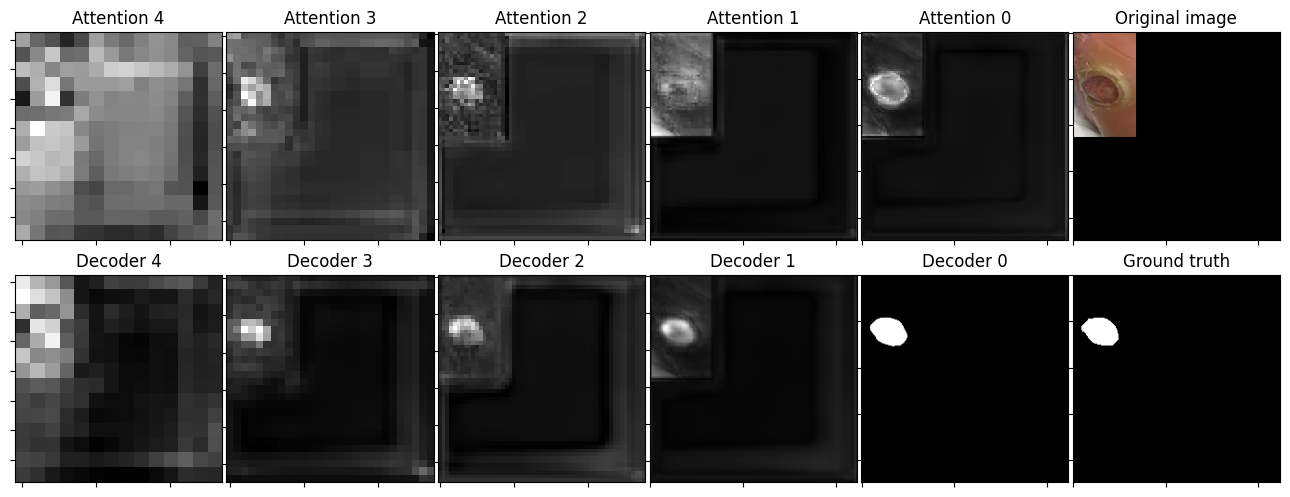

In [ ]:
fig, ax = plt.subplots(2, 6, figsize=(13, 5))

ax[0][0].imshow(b0_attn.cpu(), cmap='gray')
ax[0][0].set_xticklabels([]); ax[0][0].set_yticklabels([])
ax[0][0].set_title('Attention 4')

ax[0][1].imshow(b1_attn.cpu(), cmap='gray')
ax[0][1].set_xticklabels([]); ax[0][1].set_yticklabels([])
ax[0][1].set_title('Attention 3')

ax[0][2].imshow(b2_attn.cpu(), cmap='gray')
ax[0][2].set_xticklabels([]); ax[0][2].set_yticklabels([])
ax[0][2].set_title('Attention 2')

ax[0][3].imshow(b3_attn.cpu(), cmap='gray')
ax[0][3].set_xticklabels([]); ax[0][3].set_yticklabels([])
ax[0][3].set_title('Attention 1')

ax[0][4].imshow(b4_attn.cpu(), cmap='gray')
ax[0][4].set_xticklabels([]); ax[0][4].set_yticklabels([])
ax[0][4].set_title('Attention 0')

ax[1][0].imshow(b0_conv1.cpu(), cmap='gray')
ax[1][0].set_xticklabels([]); ax[1][0].set_yticklabels([])
ax[1][0].set_title('Decoder 4')

ax[1][1].imshow(b1_conv1.cpu(), cmap='gray')
ax[1][1].set_xticklabels([]); ax[1][1].set_yticklabels([])
ax[1][1].set_title('Decoder 3')

ax[1][2].imshow(b2_conv1.cpu(), cmap='gray')
ax[1][2].set_xticklabels([]); ax[1][2].set_yticklabels([])
ax[1][2].set_title('Decoder 2')

ax[1][3].imshow(b3_conv1.cpu(), cmap='gray')
ax[1][3].set_xticklabels([]); ax[1][3].set_yticklabels([])
ax[1][3].set_title('Decoder 1')

ax[1][4].imshow(output.squeeze().detach().cpu(), cmap='gray')
# ax[1][4].imshow(b4_conv1.cpu(), cmap='gray')
ax[1][4].set_xticklabels([]); ax[1][4].set_yticklabels([])
ax[1][4].set_title('Decoder 0')

ax[0][5].imshow(org_img)
ax[0][5].set_xticklabels([]); ax[0][5].set_yticklabels([])
ax[0][5].set_title('Original image')
ax[1][5].imshow(np.squeeze(mask), cmap='gray')
ax[1][5].set_xticklabels([]); ax[1][5].set_yticklabels([])
ax[1][5].set_title('Ground truth')

fig.tight_layout()
fig.subplots_adjust(wspace=0.02, hspace=0.1)

save_fig_dir = "/content/drive/MyDrive/Foot_ulcer_torch/plots_oldDfu/attention_output"
if not os.path.exists(save_fig_dir): os.makedirs(save_fig_dir)

fig.savefig(os.path.join(save_fig_dir, model_name + '_idx_' + str(idx) + '.png'))

In [ ]:
output.squeeze().cpu().size()

torch.Size([224, 224])

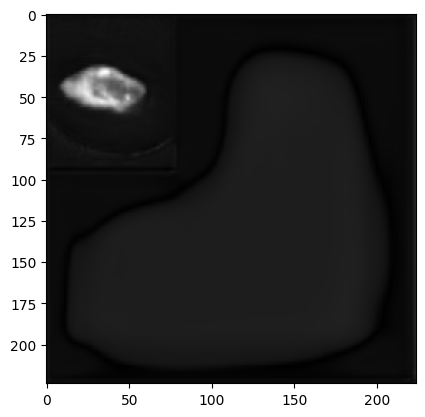

In [ ]:
plt.imshow(b4_conv1.cpu(), cmap='gray')